# Mask and Social distancing Detection 

In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import torch

In [61]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('harr/haarcascade_frontalface_default.xml')

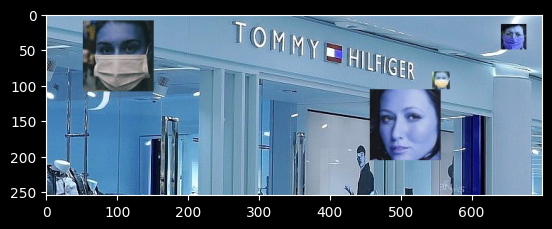

In [62]:
from random import randint
from glob import iglob
noise = cv2.imread('shopping.jpg')
x_s = randint(0,noise.shape[1]-255)
y_s = randint(0,noise.shape[0]-255)
noise = noise[y_s:y_s+255,x_s:x_s+700]
plt.imshow(noise)

face_path = iglob('FaceMask_12k/Train/*')
face_list_path = []
for folder in face_path:
    files = iglob(folder+'/*')
    for file in files:
        face_list_path.append(file)


face_list = [cv2.imread('FaceMask_12k/Test/WithMask/153.png',-1),cv2.imread('FaceMask_12k/Test/WithMask/1163.png',-1),cv2.imread('FaceMask_12k/Test/WithMask/1362.png',-1),cv2.imread('FaceMask_12k/Test/WithoutMask/1014.png',-1)]
for s_face in face_list:
    x0 = randint(0,noise.shape[1]-s_face.shape[1])
    x1 = x0+s_face.shape[1]
    y0 = randint(0,noise.shape[0]-s_face.shape[0])
    y1 = y0+s_face.shape[0]
    for c in range(3):
        noise[y0:y1,x0:x1,c]=s_face[:,:,c]
plt.imshow(noise)


(156, 400, 4)


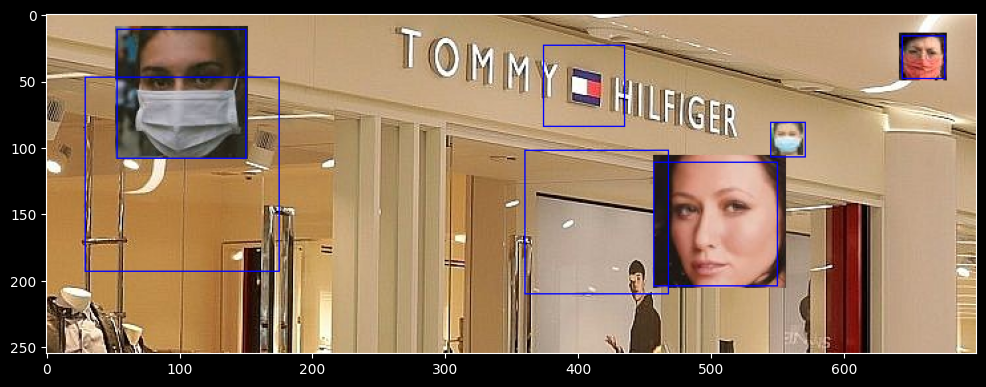

In [63]:
#trying it out on a sample image
img = cv2.imread('images/maksssksksss1.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(noise,scaleFactor=1.01, minNeighbors=4) #returns a list of (x,y,w,h) tuples
# scaleFactor: scale factor for each iteration of sliding window
# minNeighors: valid window

out_img = cv2.cvtColor(noise, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)
print(img.shape)

### Using VGG19 for mask detection


In [64]:
#Load train and test set
train_dir = 'FaceMask_12k/Train'
test_dir = 'FaceMask_12k/Test'
val_dir = 'FaceMask_12k/Validation'

In [96]:
class MaskDataset(object):
    def __init__(self, transform,path):
        self.transform = transform
        # load all image files, sorting them to
        # ensure that they are aligned
        # path in forms of 'FaceMask_12k/Test/'
        self.path = path
        self.pos_imgs = list(sorted(os.listdir(path+'/WithMask')))
        self.neg_imgs = list(sorted(os.listdir(path+'/WithoutMask')))
        self.imgs = []
        self.imgs.extend(self.pos_imgs)
        self.imgs.extend(self.neg_imgs)
        pos_label = torch.ones(len(self.pos_imgs),1,dtype=torch.float)
        neg_label = torch.zeros(len(self.neg_imgs),1,dtype=torch.float)
        self.label = torch.cat([pos_label,neg_label])
        
    def __getitem__(self, idx):
        if idx > len(self.pos_imgs):
            img = Image.open(self.path+'/WithoutMask/'+self.imgs[idx]).convert("RGB")
        else:
            img = Image.open(self.path+'/WithMask/'+self.imgs[idx]).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)

        return img, self.label[idx]

    def __len__(self):
        return len(self.imgs)

In [97]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
vgg19 = torch.hub.load("pytorch/vision:v0.10.0", "vgg19_bn", weights='VGG19_BN_Weights.DEFAULT')


Using cache found in /Users/yipkwunchuen/.cache/torch/hub/pytorch_vision_v0.10.0


### Building VGG19 transfer learning model.

In [98]:
class vgg_19_trans(torch.nn.Module):
    def __init__(self,vgg19_model) -> None:
        super().__init__()
        self.vgg_19 = vgg19_model
        self.fla = torch.nn.Flatten()
        self.sm = torch.nn.Softmax()
        self.lr = torch.nn.Linear(1000,2)
    
    def forward(self,x):
        x = self.vgg_19(x)
        x = self.fla(x)
        x = self.sm(x)
        x = self.lr(x)
        return x
    
model = vgg_19_trans(vgg19)


In [99]:
train_data = MaskDataset(transform,train_dir)

In [100]:
img_tensor,label_tensor = train_data.__getitem__(0)
img = np.asarray(img_tensor.tolist())

# print(img)
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
# img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
# plt.imshow(img)

In [101]:
num_epochs = 5

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
loss_func = torch.nn.CrossEntropyLoss()


for epoch in range(num_epochs):
    model.train()
    i = 0    
    train_epoch_loss = 0
    val_epoch_loss = 0
    running_loss = 0
    for img, annotation in train_data:
        i += 1
        pred = model(img.unsqueeze_(dim=0))
        print(pred,annotation)
        loss = loss_func(pred,annotation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.items()
        if i % 20 == 0:
            print(
            f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}",
            end="\t",
        )

tensor([[0.0015, 0.0187]], grad_fn=<AddmmBackward0>) tensor([1.])


/var/folders/q1/1tqmfyd524l_sn2xn11xpfy40000gn/T/ipykernel_44946/1732909471.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sm(x)


RuntimeError: expected scalar type Long but found Float